In [1]:
import numpy as np
import pandas as pd
import random
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
%matplotlib inline

# qiskit modules
import qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector, plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity, DensityMatrix
from qiskit.providers.aer import noise

# tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

# readout calibration
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [2]:
# importing IBMQ backends
from qiskit import IBMQ
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
simulator_noise = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmqx2') #ibmqx2 ibmq_16_melbourne ibmq_ourense ibmq_burlington
properties = device.properties()
noise_model = noise.device.basic_device_noise_model(properties)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

C:\Users\Niels\Envs\dev_qiskit\lib\site-packages\qiskit\providers\aer\noise\device\basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


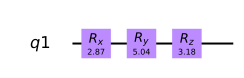

In [3]:
R=[]
for i in range(3):
    R.append(10*random.random()) 
n=3
qreg = QuantumRegister(n)
qreg_exp = QuantumRegister(1)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.rx(np.pi/5*R[0],0)
qc_expected.ry(np.pi/5*R[1],0)
qc_expected.rz(np.pi/5*R[2],0)
qc_expected.draw(output='mpl')

The expected state is: [ 0.58600268+0.j         -0.78563565+0.19843761j]


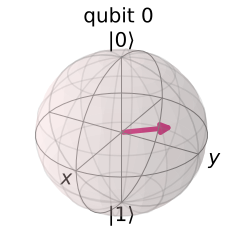

In [4]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_bloch_multivector(psi_expected)

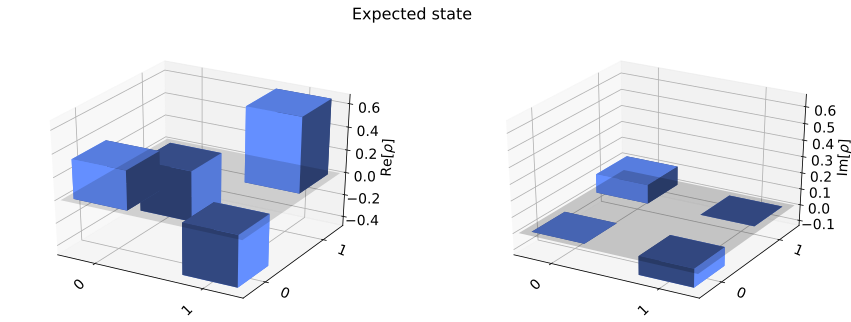

In [5]:
plot_state_city(psi_expected, title='Expected state')

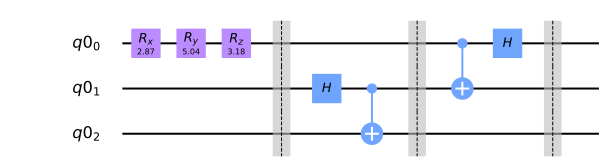

In [6]:
qc = QuantumCircuit(qreg)
qc.rx(np.pi/5*R[0],0)
qc.ry(np.pi/5*R[1],0)
qc.rz(np.pi/5*R[2],0)
qc.barrier()
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.draw(output='mpl')

Job Status: job has successfully run


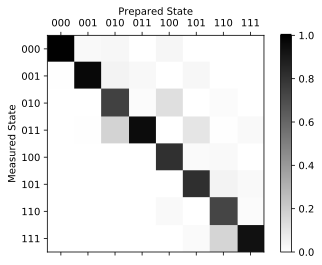

In [7]:
#readout calibration measurements
cal_circuits, state_labels = complete_meas_cal(qr = qc.qregs[0], circlabel = 'measerrormitcal')
cal_job = qiskit.execute(cal_circuits,backend = device,shots = 8192, optimization_level = 0)
job_monitor(cal_job)
calres = cal_job.result()
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()

In [8]:
counts =[0,0,0,0,0,0,0,0]
bits = ['000', '100', '001', '101', '010', '110', '011', '111']
for num, bbit in enumerate(bits):
    counts[num]=calres.get_counts(cal_circuits[num])
    for bit in bits:
        if bit not in counts[num]:
            counts[num][bit] = 0

count = [0,0,0,0]
for j in range(4):
    for num, bit in enumerate(bits):
        if num%2 == 0:
            count[0] += counts[j][bit]
            count[2] += counts[j+4][bit]
        if num%2 == 1:
            count[1] += counts[j][bit]
            count[3] += counts[j+4][bit]

countsdev = {'00':count[0], '01':count[1], '10':count[2], '11':count[3]}

epsilon01=countsdev["01"]/(8192*8)
epsilon10=countsdev["10"]/(8192*8)
beta0=(epsilon10-epsilon01)
beta1=1-epsilon10-epsilon01
# plot_histogram(countsdev)

print('The value of beta 0:', beta0)
print('The value of beta 1:', beta1)
# The value of beta 0: 0.04475
# The value of beta 1: 0.951125

The value of beta 0: 0.0438385009765625
The value of beta 1: 0.9531097412109375


In [9]:
# defining the tomography circuits
qst_full_circuits = state_tomography_circuits(qc,qreg)
# the three circuits are in the order [ZZX, ZZY, ZZZ]
qst_circuit = [qst_full_circuits[24], qst_full_circuits[25], qst_full_circuits[26]]

In [10]:
bits = ['000', '100', '001', '101', '010', '110', '011', '111']

backends = [simulator, simulator_noise, device]
paulis = [('Z','Z','X'), ('Z','Z','Y'), ('Z','Z','Z')]
basis = ['X', 'Y', 'Z']
for num, backend in enumerate(backends):
    state = {'X': {'0': 0, '1': 0}, 'Y': {'0': 0, '1': 0}, 'Z': {'0': 0, '1': 0}}
    state_df = pd.DataFrame(data=[state,state,state,state])
    if num == 0:
        job_sim = qiskit.execute(qst_circuit, backend, shots=8192) # for ideal simulator
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 1:
        job_sim = qiskit.execute(qst_circuit, backend, shots=8192,noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 2:
        job_dev = qiskit.execute(qst_circuit, backend, shots=8192)
        job_monitor(job_dev)
        tom = StateTomographyFitter(job_dev.result(), qst_circuit)
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit]=0
    # 4 possible outcomes of teleport protocol, where the final state is either
    # psi, X @ psi, Z @ psi, X @ Z @ psi. We store all 4 seperately, to then transform
    # the resulting density matrices appropriately before finding fidelity
    for i in range(4):
        for j in range(3):
            state_df.loc[i][basis[j]] = {'0': tom.data[(paulis[j])][bits[2*i]],
                                         '1': tom.data[(paulis[j])][bits[2*i+1]]}
    if num == 0:
        state_sim = state_df
        print('The full state for the simulator is', state_sim)
    if num == 1:
        state_sim_noise = state_df
        print('The full state for the noisy simulator is', state_sim_noise)
    if num == 2:
        state_dev = state_df
        print('The full state for the device is', state_dev)

The full state for the simulator is                       X                      Y                      Z
0  {'0': 75, '1': 2009}  {'0': 1231, '1': 770}  {'0': 700, '1': 1352}
1  {'0': 1982, '1': 74}  {'0': 763, '1': 1308}  {'0': 693, '1': 1368}
2  {'0': 76, '1': 1918}  {'0': 766, '1': 1279}  {'0': 1297, '1': 713}
3  {'0': 1973, '1': 85}  {'0': 1298, '1': 777}  {'0': 1400, '1': 669}
The full state for the noisy simulator is                        X                      Y                      Z
0  {'0': 174, '1': 1921}  {'0': 1269, '1': 869}  {'0': 822, '1': 1276}
1  {'0': 1941, '1': 140}  {'0': 877, '1': 1205}  {'0': 787, '1': 1356}
2  {'0': 205, '1': 1830}  {'0': 834, '1': 1169}  {'0': 1267, '1': 697}
3  {'0': 1837, '1': 144}  {'0': 1201, '1': 768}  {'0': 1304, '1': 683}
Job Status: job has successfully run
The full state for the device is                        X                       Y                      Z
0  {'0': 303, '1': 1475}   {'0': 768, '1': 1122}  {'0': 668, '1': 1080}
1  

In [11]:
# fidelity processing for sim and dev
Iden = np.matrix('1, 0; 0, 1')
XPaul = np.matrix('0, 1; 1, 0')
YPaul = np.matrix('0, 0-1j; 0+1j, 0')
ZPaul = np.matrix('1, 0; 0, -1')

state_tot=[state_sim,state_sim_noise,state_dev,0]
rho2=[0,0,0,0]
r_tot=np.zeros((4, 3))
for k,states in enumerate(state_tot):
    rho_tot=[0,0,0,0]
    if k == 3:
        r_tot[:,:] = (r_tot[:,:] - beta0) / beta1
    else:
        for i in range(4):
            for j in range(3):
                r_tot[i,j] = (state_tot[k][basis[j]][i]['0']*1 + state_tot[k][basis[j]][i]['1']*(-1))/(state_tot[k][basis[j]][i]['0'] + state_tot[k][basis[j]][i]['1'])
    for i in range(4):
        rho_tot[i] = (1/2)*(Iden+r_tot[i,0]*XPaul+r_tot[i,1]*YPaul+r_tot[i,2]*ZPaul)
    rho2[k]=rho_tot
rho = pd.DataFrame(data=[rho2[0],rho2[1],rho2[2],rho2[3]])
for ind in range(4):
    rho.loc[ind][1] = ZPaul @ rho.loc[ind][1] @ ZPaul
    rho.loc[ind][2] = XPaul @ rho.loc[ind][2] @ XPaul
    rho.loc[ind][3] = ZPaul @ XPaul @ rho.loc[ind][3] @ XPaul @ ZPaul

In [12]:
Fidelity = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        Fidelity[i,j] = state_fidelity(psi_expected, rho[j][i], validate=False)      
F = np.mean(Fidelity,axis=1)
print('Simulator Fidelity:', F[0])
print('Noisy Simulator Fidelity:', F[1])
print('Device Fidelity:', F[2])
print('Corrected Device Fidelity:', F[3])

Simulator Fidelity: 1.0049428754454535
Noisy Simulator Fidelity: 0.94959701733742
Device Fidelity: 0.8431375006151033
Corrected Device Fidelity: 0.8600188790213632


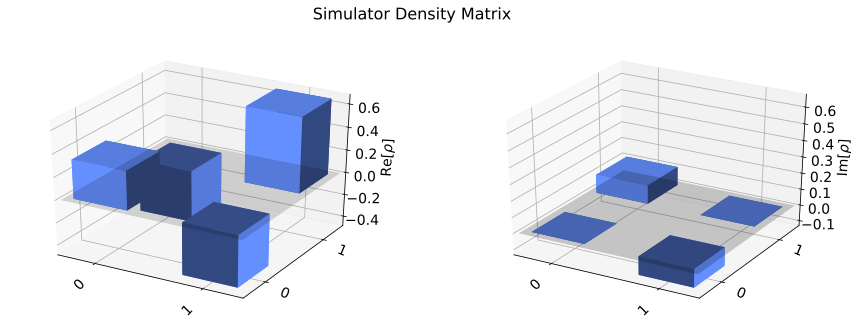

In [13]:
plot_state_city(rho[0][0], title='Simulator Density Matrix')

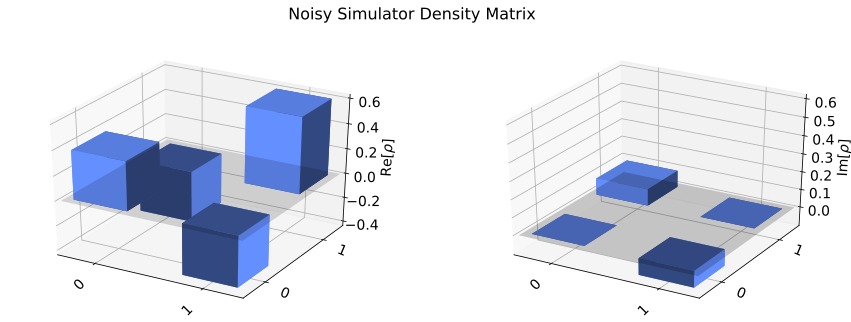

In [14]:
plot_state_city(rho[0][1], title='Noisy Simulator Density Matrix')

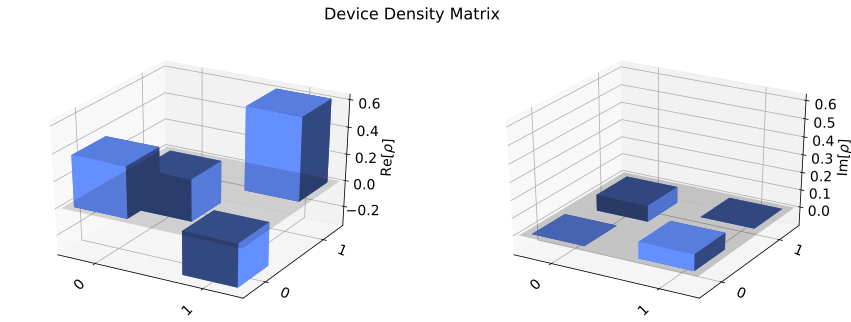

In [15]:
plot_state_city(rho[0][2], title='Device Density Matrix')

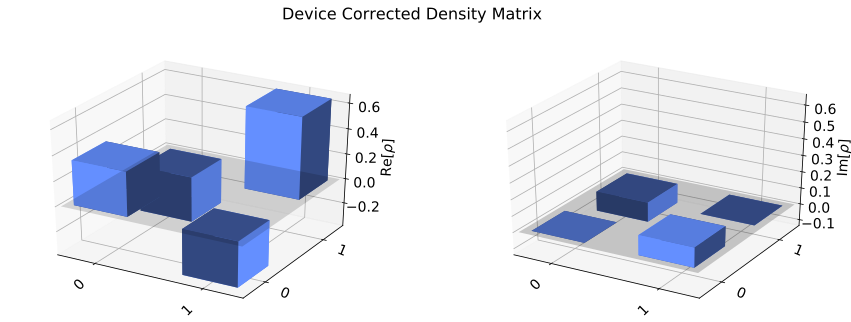

In [16]:
plot_state_city(rho[0][3], title='Device Corrected Density Matrix')

In [17]:
# checking validity of the density matrices, little problem with the simulator one...

rho_sim = DensityMatrix(rho[0][0])
rho_dev = DensityMatrix(rho[0][1])

In [18]:
print('Is the simulator density matrix valid?', rho_sim.is_valid())
print('Is the device density matrix valid?', rho_dev.is_valid())

Is the simulator density matrix valid? False
Is the device density matrix valid? True


In [19]:
import qiskit.tools.jupyter
%qiskit_version_table

In [20]:
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

In [21]:
IBMQ.active_account()

{'token': '4eb9b7f945020d8a9856c0f0e74c53ba48cbe0f3740dda1c0cb5a15240cf82330940fdef3a406c118662945b55e2655807948f63dd7ff57343d6fb491cd121b9',
 'url': 'https://auth.quantum-computing.ibm.com/api'}